# Without deactivation over time

[init] For pH0 = 7.36, strong-ion net (Na+ - Cl-) = 0.0000 M
[████████████████████████████████████████] time 100.000% | conv~100.000%
Finished at t = 191288.7 s when S < 0.0001% of S0.
Data → simulation_results.csv; figures saved as PNGs.


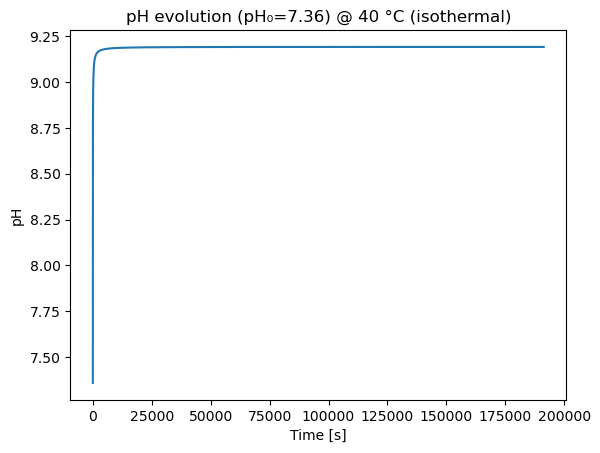

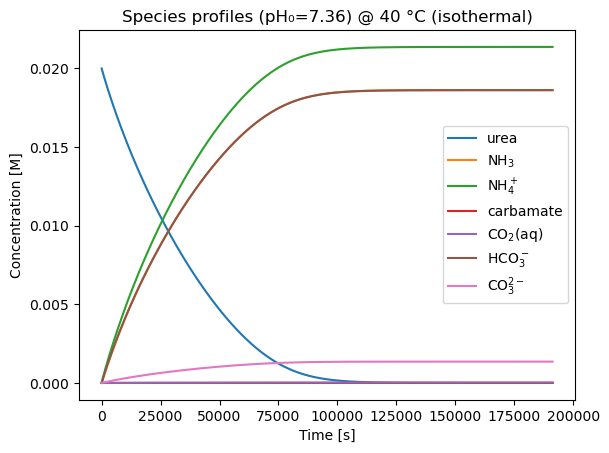

In [5]:
# Urease–urea batch reactor @ 40 °C (default isothermal), with optional
# unit-correct energy balance (adiabatic/jacketed), optional competitive
# phosphate inhibition, ASCII progress bar, temperature-dependent Kw,
# temperature-specific pH-activity, and optional carbamate speciation.
#
# Stoich: urea -> 2 NH3 + CO2
#
# Notes:
# - Product inhibition Kp(pH) from Qin & Cabral (1994), table-based, clamped.
# - pH-activity params are temperature-specific: linear interpolation between 25 °C and 40 °C.
# - Kw(T) via a small pKw(T) table (298.15 K, 308.15 K, 313.15 K, 323.15 K); linear interpolation with clamping.
# - Optional carbamate: NH3 + CO2 ⇌ NH2COO− + H+. Implemented analytically within speciation.
#   Default is OFF unless you supply a reasonable Kcarb (dimensionless) for your conditions.

import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

# ╔══════════════════════════════════════════════════════════════╗
# ║                       USER SETTINGS                          ║
# ╚══════════════════════════════════════════════════════════════╝

# Volume & enzyme loading
volume_L               = 0.2           # reactor liquid volume [L]
grams_urease_powder    = 0.1           # mass of (effective) urease powder [g]
powder_activity_frac   = 1.0           # 0–1 scale for purity/activity
E_loading_g_per_L      = grams_urease_powder * powder_activity_frac / volume_L  # g/L

activity_from_experiment= 1.0

# Initial pH control (set None to disable)
initial_pH             = 7.36          # e.g., 6.0, 7.2, 8.5, or None

# Temperature control
isothermal             = True          # True: fixed 40 °C; False: simulate T
fixed_temperature_K    = 313.15        # 40 °C (also used as initial T if non-isothermal)

# If isothermal == False, choose adiabatic/jacketed energy balance
adia                   = True          # only used if isothermal=False
UA_W_per_K             = 100.0         # overall U*A [W/K], if jacketed
T_jacket_K             = 313.15        # jacket temperature [K]
rho_kg_per_L           = 1.0           # per-liter basis
Cp_J_per_kgK           = 4184.0        # water cp
deltaH_J_per_mol       = -70.5e3       # reaction enthalpy (exothermic, keep negative)

# Chemistry: initial totals (no CO₂ steering)
S0                     = 0.020         # urea [M] (20 mM)
N0                     = 0.0           # total ammonia nitrogen [M] (NHx produced by urease)
C0                     = 0.0           # total inorganic carbon [M]
Pt_total_M             = 0.0           # total phosphate [M]; 0.0 = no phosphate

# Optional carbamate equilibrium NH3 + CO2 ⇌ NH2COO- + H+
include_carbamate      = False         # set True if you have a good Kcarb
Kcarb_dimensionless    = 1.0e-3        # K = [Carb][H+]/([NH3][CO2]); tune to your data if enabling

# Time control
auto_finish            = True          # stop when urea ~depleted
urea_cut_frac          = 1e-6          # stop when S < urea_cut_frac * S0
t_final_s              = 2000          # used only if auto_finish=False
n_points               = 150000          # samples written to CSV/plots

# Progress bar
show_progress          = True          # tqdm-like ASCII bar in terminal
progress_chunks        = 60            # number of chunks printed in bar

# Output
make_plots             = True
csv_path               = "simulation_results.csv"

# ╔══════════════════════════════════════════════════════════════╗
# ║                  CONSTANTS & PARAMETERS                      ║
# ╚══════════════════════════════════════════════════════════════╝

R   = 8.314  # J/mol/K

# Kinetics from Qin & Cabral (1994), per gram of enzyme
# k0 is a frequency factor (pre-exponential), NOT a Vmax at Tref.
k0_mol_per_s_per_g = 0.267 * activity_from_experiment   # mol NH3/(s·g) (frequency factor)
Ea    = 29.1e3                # J/mol
KM, Ks = 2.56e-3, 6.18        # M (Ks is indeed large in the paper)

# pH-activity parameters depend on temperature.
# 25 °C (298.15 K): pKa_es1=9.07, pKa_es2=5.62, alpha=0.373, beta=0.564
# 40 °C (313.15 K): pKa_es1=9.58, pKa_es2=5.15, alpha=0.542, beta=0.769
_PH_ACT_TABLE = [
    (298.15, 9.07, 5.62, 0.373, 0.564),
    (313.15, 9.58, 5.15, 0.542, 0.769),
]

def _interp_linear(x, x0, x1, y0, y1):
    if x <= x0: return y0
    if x >= x1: return y1
    w = (x - x0) / (x1 - x0)
    return y0 + w * (y1 - y0)

def pH_activity_params(TK):
    # linear interpolation between 25 °C and 40 °C
    (T0, pKa1_0, pKa2_0, a0, b0), (T1, pKa1_1, pKa2_1, a1, b1) = _PH_ACT_TABLE
    pKa1 = _interp_linear(TK, T0, T1, pKa1_0, pKa1_1)
    pKa2 = _interp_linear(TK, T0, T1, pKa2_0, pKa2_1)
    alpha = _interp_linear(TK, T0, T1, a0, a1)
    beta  = _interp_linear(TK, T0, T1, b0, b1)
    return pKa1, pKa2, alpha, beta

# ── Product inhibition Kp(pH) from Qin & Cabral (1994), table-based, clamped
_KP_POINTS = [
    (6.25, 0.1785),
    (6.50, 0.1194),
    (7.00, 0.0693),
    (7.50, 0.0386),
    (8.00, 0.0311),
    (8.50, 0.0327),
    (8.75, 0.0298),
    (9.00, 0.0310),
]
def Kp_of_pH(pH):
    pts = _KP_POINTS
    if pH <= pts[0][0]:
        return pts[0][1]
    if pH >= pts[-1][0]:
        return pts[-1][1]
    for (pa, Ka), (pb, Kb) in zip(pts, pts[1:]):
        if pa <= pH <= pb:
            w = (pH - pa) / (pb - pa)
            return Ka + w * (Kb - Ka)
    return pts[-1][1]

# Optional competitive phosphate inhibition (H2PO4- + HPO4^2- as “active”)
Ki_phosphate = 0.010  # [M] — larger means negligible inhibition; set None to disable

# Temperature-dependent water autoprotolysis (pKw table; clamp & linear interp)
# Typical values (pure water): 25°C:14.00, 35°C:~13.73, 40°C:~13.54, 50°C:~13.26
_PKW_TABLE = [
    (298.15, 14.00),
    (308.15, 13.73),
    (313.15, 13.54),
    (323.15, 13.26),
]
def pKw_of_T(TK):
    # piecewise linear interpolation with clamping
    if TK <= _PKW_TABLE[0][0]:
        return _PKW_TABLE[0][1]
    if TK >= _PKW_TABLE[-1][0]:
        return _PKW_TABLE[-1][1]
    for (Ta, pKwa), (Tb, pKwb) in zip(_PKW_TABLE, _PKW_TABLE[1:]):
        if Ta <= TK <= Tb:
            return _interp_linear(TK, Ta, Tb, pKwa, pKwb)
    return _PKW_TABLE[-1][1]

def Kw_of_T(TK):
    return 10.0 ** (-pKw_of_T(TK))

# Acid–base constants (held fixed; acceptable near 40 °C if you don't vary T far)
Ka_NH4 = 5.62e-10         # NH4+ ⇌ NH3 + H+
Ka1    = 4.45e-7          # H2CO3 ⇌ HCO3– + H+
Ka2    = 4.69e-11         # HCO3– ⇌ CO3^2–
# Phosphate triprotic
Ka1p   = 7.11e-3          # H3PO4 ⇌ H2PO4– + H+
Ka2p   = 6.32e-8          # H2PO4– ⇌ HPO4^2– + H+
Ka3p   = 4.22e-13         # HPO4^2– ⇌ PO4^3–

# ╔══════════════════════════════════════════════════════════════╗
# ║       INITIAL pH: STRONG-ION BACKGROUND (Na+ - Cl-)          ║
# ╚══════════════════════════════════════════════════════════════╝

B_STRONG = 0.0  # net strong-ion background [M], conserved

def _B_for_target_pH(pH_target, Ntot, Ctot, Ptot, T):
    """Compute net strong-ion background (Na+ - Cl-) [M] that yields pH_target under electroneutrality."""
    H  = 10**(-pH_target)
    Kw = Kw_of_T(T)
    OH = Kw / H

    # (carbamate handled below via helper)
    spec = _species_given_pH(H, Ntot, Ctot, Ptot, T, include_carbamate, Kcarb_dimensionless)
    NH4, HCO3, CO3, H2PO4, HPO4, PO4, Carb = spec['NH4'], spec['HCO3'], spec['CO3'], spec['H2PO4'], spec['HPO4'], spec['PO4'], spec['Carb']

    # From electroneutrality: (H + NH4 + Na+) = (OH + HCO3 + 2CO3 + H2PO4 + 2HPO4 + 3PO4 + Carb + Cl-)
    # Let B = [Na+] - [Cl-]. Rearranged: B = RHS - LHS (without Na+/Cl-).
    B = (OH + HCO3 + 2*CO3 + H2PO4 + 2*HPO4 + 3*PO4 + Carb) - (H + NH4)
    return B

# ╔══════════════════════════════════════════════════════════════╗
# ║              SPECIATION & pH  (charge balance)               ║
# ╚══════════════════════════════════════════════════════════════╝

_SPEC_LAST_pH = {"val": 7.0}  # warm start for root bracketing

def _carbon_alpha(H):
    # fraction functions for carbonate system (sum to 1)
    denom = H*H + Ka1*H + Ka1*Ka2
    a0 = H*H / denom           # CO2(aq)
    a1 = Ka1 * H / denom       # HCO3-
    a2 = Ka1 * Ka2 / denom     # CO3(2-)
    return a0, a1, a2

def _species_given_pH(H, Ntot, Ctot, Ptot, T, use_carbamate, Kcarb):
    Kw = Kw_of_T(T)
    OH = Kw / H

    # phosphate distributions
    Dp   = H**3 + Ka1p*H**2 + Ka1p*Ka2p*H + Ka1p*Ka2p*Ka3p
    H2PO4 = Ptot * (Ka1p * H**2 / Dp)
    HPO4  = Ptot * (Ka1p * Ka2p * H / Dp)
    PO4   = Ptot * (Ka1p * Ka2p * Ka3p / Dp)

    # If no carbamate: classic NH3/NH4 and carbonate split
    if not use_carbamate or Kcarb <= 0.0 or Ctot <= 0.0 or Ntot <= 0.0:
        NH4 = Ntot * (H / (H + Ka_NH4))
        NH3 = Ntot - NH4
        a0, a1, a2 = _carbon_alpha(H)
        CO2  = Ctot * a0
        HCO3 = Ctot * a1
        CO3  = Ctot * a2
        Carb = 0.0
        return {
            'H': H, 'OH': OH, 'NH3': NH3, 'NH4': NH4,
            'CO2': CO2, 'HCO3': HCO3, 'CO3': CO3,
            'H2PO4': H2PO4, 'HPO4': HPO4, 'PO4': PO4,
            'Carb': Carb
        }

    # With carbamate: solve analytically for N_free (NH3+NH4) and Carb
    a0, a1, a2 = _carbon_alpha(H)  # CO2, HCO3, CO3 fractions for the "free" carbon pool
    Ka = Ka_NH4
    beta = Kcarb * a0 / H                  # beta(H)
    gamma = beta * Ka / (H + Ka)          # gamma(H)

    # Quadratic for N_free: a*x^2 + b*x + c = 0, where x = N_free
    a = gamma
    b = 1.0 - gamma * (Ntot - Ctot)
    c = -Ntot

    if a <= 1e-20:
        N_free = max(Ntot, 0.0)
    else:
        disc = b*b - 4*a*c
        disc = max(disc, 0.0)
        N_free = ( -b + math.sqrt(disc) ) / (2*a)
        # Clamp physically
        N_free = max(min(N_free, max(Ntot, 0.0)), 0.0)

    # Now get Carb, then NH3/NH4 and the carbon species
    # Carb = (gamma*N_free)/(1 + gamma*N_free) * Ctot
    if gamma * N_free > 1e-20:
        Carb = (gamma * N_free / (1.0 + gamma * N_free)) * Ctot
    else:
        Carb = 0.0

    C_free = max(Ctot - Carb, 0.0)
    CO2  = a0 * C_free
    HCO3 = a1 * C_free
    CO3  = a2 * C_free

    # Ammonia speciation out of N_free
    NH4 = N_free * (H / (H + Ka))
    NH3 = N_free - NH4

    return {
        'H': H, 'OH': OH, 'NH3': max(NH3,0.0), 'NH4': max(NH4,0.0),
        'CO2': max(CO2,0.0), 'HCO3': max(HCO3,0.0), 'CO3': max(CO3,0.0),
        'H2PO4': H2PO4, 'HPO4': HPO4, 'PO4': PO4,
        'Carb': max(Carb,0.0)
    }

def _charge_balance_residual(pH, Ntot, Ctot, Ptot, T):
    H  = 10**(-pH)
    spec = _species_given_pH(H, Ntot, Ctot, Ptot, T, include_carbamate, Kcarb_dimensionless)
    OH = spec['OH']
    NH4 = spec['NH4']
    HCO3, CO3 = spec['HCO3'], spec['CO3']
    H2PO4, HPO4, PO4 = spec['H2PO4'], spec['HPO4'], spec['PO4']
    Carb = spec['Carb']

    # electroneutrality INCLUDING strong-ion background B_STRONG
    # (H + NH4 + Na+) - (OH + HCO3 + 2CO3 + H2PO4 + 2HPO4 + 3PO4 + Carb + Cl-) = 0
    # residual = LHS - RHS + B_STRONG
    return (H + NH4) - (OH + HCO3 + 2*CO3 + H2PO4 + 2*HPO4 + 3*PO4 + Carb) + B_STRONG

def compute_speciation(Ntot, Ctot, Ptot, T):
    """Return dict with pH and species for given totals at temperature T."""
    Ntot = max(Ntot, 0.0); Ctot = max(Ctot, 0.0); Ptot = max(Ptot, 0.0)

    # bracket around last pH guess
    pH0 = _SPEC_LAST_pH["val"]
    lo = max(1.0, pH0 - 3.0)
    hi = min(13.0, pH0 + 3.0)

    f_lo = _charge_balance_residual(lo, Ntot, Ctot, Ptot, T)
    f_hi = _charge_balance_residual(hi, Ntot, Ctot, Ptot, T)
    if f_lo * f_hi > 0:
        lo, hi = 1.0, 13.0

    sol = root_scalar(_charge_balance_residual, bracket=[lo, hi], method='brentq',
                      args=(Ntot, Ctot, Ptot, T))
    pH = float(sol.root)
    _SPEC_LAST_pH["val"] = pH

    H  = 10**(-pH)
    spec = _species_given_pH(H, Ntot, Ctot, Ptot, T, include_carbamate, Kcarb_dimensionless)
    spec.update({'pH': pH})
    return spec

# ╔══════════════════════════════════════════════════════════════╗
# ║                        RATE LAW                              ║
# ╚══════════════════════════════════════════════════════════════╝

def rate_per_g(S, Ntot, pH, T, P_inhib):
    """
    NH3 formation rate per gram of urease [mol/(g·s)].
    Arrhenius + temperature-specific pH activity + substrate inhibition
    + noncomp product inhibition (Kp(pH)) + optional competitive phosphate.
    """
    S = max(S, 0.0)

    # Arrhenius with k0 as frequency factor
    kT = k0_mol_per_s_per_g * math.exp(-Ea / (R * T))

    # pH activity (two-site), params interpolated by T
    pKa_es1, pKa_es2, alpha_e, beta_e = pH_activity_params(T)
    Kes1, Kes2 = 10**(-pKa_es1), 10**(-pKa_es2)
    H = 10**(-pH)
    pH_factor = 1.0 / (1.0 + (Kes1/H)**alpha_e + (H/Kes2)**beta_e)

    # competitive phosphate
    if Ki_phosphate is None or Ki_phosphate <= 0.0:
        alpha_comp = 1.0
    else:
        alpha_comp = 1.0 + P_inhib / Ki_phosphate

    denom = max(KM * alpha_comp + S + (S*S)/Ks, 1e-12)
    v_sub = kT * pH_factor * (S / denom)

    # noncompetitive product inhibition (uses total ammonia Ntot with pH-dependent Kp)
    v = v_sub / (1.0 + max(Ntot, 0.0) / max(Kp_of_pH(pH), 1e-12))
    return v

# ╔══════════════════════════════════════════════════════════════╗
# ║                        ODE SYSTEM                            ║
# ╚══════════════════════════════════════════════════════════════╝

def rhs_isothermal(t, y):
    """y = [S, Ntot, Ctot]; T is fixed."""
    S, Ntot, Ctot = y
    sp  = compute_speciation(Ntot, Ctot, Pt_total_M, fixed_temperature_K)
    pH  = sp['pH']
    Pin = sp['H2PO4'] + sp['HPO4']
    per_g = rate_per_g(S, Ntot, pH, fixed_temperature_K, Pin)
    r_NH3 = per_g * E_loading_g_per_L               # mol/L/s
    dS_dt = -0.5 * r_NH3                             # urea → 2 NH3 + CO2
    dN_dt =       r_NH3
    dC_dt =  0.5 * r_NH3
    return [dS_dt, dN_dt, dC_dt]

def rhs_energy(t, y):
    """y = [S, Ntot, Ctot, T]; per-liter energy balance."""
    S, Ntot, Ctot, T = y
    sp  = compute_speciation(Ntot, Ctot, Pt_total_M, T)
    pH  = sp['pH']
    Pin = sp['H2PO4'] + sp['HPO4']
    per_g = rate_per_g(S, Ntot, pH, T, Pin)
    r_NH3 = per_g * E_loading_g_per_L               # mol/L/s
    dS_dt = -0.5 * r_NH3
    dN_dt =       r_NH3
    dC_dt =  0.5 * r_NH3

    # heat release per liter
    r_urea = -dS_dt                                  # mol urea / (L·s)
    q_rxn_per_L = (-deltaH_J_per_mol) * r_urea       # J / (L·s)

    if adia:
        dT_dt = q_rxn_per_L / (rho_kg_per_L * Cp_J_per_kgK)
    else:
        UA_per_L = UA_W_per_K / volume_L             # W/K/L = J/(s·K·L)
        dT_dt = (q_rxn_per_L - UA_per_L * (T - T_jacket_K)) / (rho_kg_per_L * Cp_J_per_kgK)

    return [dS_dt, dN_dt, dC_dt, dT_dt]

def event_urea_depleted(t, y):
    S = y[0]
    return S - urea_cut_frac * S0
event_urea_depleted.terminal  = True
event_urea_depleted.direction = -1

# ╔══════════════════════════════════════════════════════════════╗
# ║               PROGRESS BAR & CHUNKED INTEGRATION             ║
# ╚══════════════════════════════════════════════════════════════╝

def _print_bar(frac_time, frac_conv, width=40):
    """ASCII progress bar: shows time progress and conversion estimate."""
    frac_time = max(0.0, min(1.0, frac_time))
    frac_conv = max(0.0, min(1.0, frac_conv))
    done = int(width * frac_time)
    bar  = '█' * done + '░' * (width - done)
    msg  = f"\r[{bar}] time {100*frac_time:5.3f}% | conv~{100*frac_conv:5.3f}%"
    sys.stdout.write(msg); sys.stdout.flush()

def integrate_with_progress(rhs, y0, times, chunks=50):
    """Integrate in 'chunks' and print a progress bar."""
    T_out = []
    Y_out = []
    edges = np.linspace(times[0], times[-1], chunks + 1)
    y_curr = np.array(y0, dtype=float)

    for k in range(chunks):
        t_a, t_b = edges[k], edges[k+1]
        mask = (times >= t_a) & (times <= t_b)
        t_eval_chunk = times[mask]
        if t_eval_chunk.size == 0:
            continue

        sol = solve_ivp(rhs, [t_a, t_b], y_curr, method='BDF',
                        t_eval=t_eval_chunk, max_step=60.0,
                        rtol=1e-6, atol=1e-12)
        if not sol.success:
            raise RuntimeError(f"Solve failed in chunk {k}: {sol.message}")

        if len(T_out) == 0:
            T_out = list(sol.t)
            Y_out = [arr.copy() for arr in sol.y]
        else:
            T_out.extend(list(sol.t[1:]))
            for i in range(len(sol.y)):
                Y_out[i] = np.concatenate((Y_out[i], sol.y[i][1:]))

        y_curr = sol.y[:, -1]

        # progress
        S_last = y_curr[0]
        frac_time = (t_b - times[0]) / (times[-1] - times[0] + 1e-12)
        denom = S0 * (1.0 - urea_cut_frac)
        frac_conv = min(1.0, max(0.0, (S0 - max(S_last, 0.0)) / (denom + 1e-30)))
        if show_progress:
            _print_bar(frac_time, frac_conv)

    if show_progress:
        sys.stdout.write("\n")
    return np.array(T_out), np.vstack(Y_out)

# ╔══════════════════════════════════════════════════════════════╗
# ║                INITIALIZE B_STRONG (from initial_pH)         ║
# ╚══════════════════════════════════════════════════════════════╝

if initial_pH is not None:
    T_for_init = fixed_temperature_K  # initial temperature context
    B_STRONG = _B_for_target_pH(initial_pH, N0, C0, Pt_total_M, T_for_init)
    _SPEC_LAST_pH["val"] = initial_pH  # warm start near requested pH
    print(f"[init] For pH0 = {initial_pH:.2f}, strong-ion net (Na+ - Cl-) = {B_STRONG:.4f} M")
else:
    B_STRONG = 0.0

# ╔══════════════════════════════════════════════════════════════╗
# ║                  SOLVE & BUILD DATAFRAME                     ║
# ╚══════════════════════════════════════════════════════════════╝

if isothermal:
    rhs = rhs_isothermal
    y0  = [S0, N0, C0]
else:
    rhs = rhs_energy
    y0  = [S0, N0, C0, fixed_temperature_K]

if auto_finish:
    sol_probe = solve_ivp(rhs, [0, 1e7], y0, method='BDF',
                          events=event_urea_depleted, max_step=60.0,
                          rtol=1e-6, atol=1e-12)
    if len(sol_probe.t_events) > 0 and len(sol_probe.t_events[0]) > 0:
        t_target = float(sol_probe.t_events[0][0])
    else:
        t_target = float(sol_probe.t[-1])
else:
    t_target = float(t_final_s)

times = np.linspace(0.0, t_target, n_points)
T_out, Y_out = integrate_with_progress(rhs, y0, times, chunks=progress_chunks)

records = []
if isothermal:
    for t, S, Ntot, Ctot in zip(T_out, *Y_out):
        sp = compute_speciation(Ntot, Ctot, Pt_total_M, fixed_temperature_K)
        records.append({
            'time [s]': t,
            'urea [M]': max(S, 0.0),
            'total ammonia [M]': max(Ntot, 0.0),
            'total inorganic carbon [M]': max(Ctot, 0.0),
            'pH': sp['pH'],
            'NH3 [M]': sp['NH3'],
            'NH4+ [M]': sp['NH4'],
            'Carbamate [M]': sp['Carb'],
            'CO2(aq) [M]': sp['CO2'],
            'HCO3- [M]': sp['HCO3'],
            'CO3(2-) [M]': sp['CO3'],
            'H2PO4- [M]': sp['H2PO4'],
            'HPO4(2-) [M]': sp['HPO4'],
            'PO4(3-) [M]': sp['PO4'],
            'T [K]': fixed_temperature_K,
            'T [°C]': fixed_temperature_K - 273.15
        })
else:
    for t, S, Ntot, Ctot, T in zip(T_out, *Y_out):
        sp = compute_speciation(Ntot, Ctot, Pt_total_M, T)
        records.append({
            'time [s]': t,
            'urea [M]': max(S, 0.0),
            'total ammonia [M]': max(Ntot, 0.0),
            'total inorganic carbon [M]': max(Ctot, 0.0),
            'pH': sp['pH'],
            'NH3 [M]': sp['NH3'],
            'NH4+ [M]': sp['NH4'],
            'Carbamate [M]': sp['Carb'],
            'CO2(aq) [M]': sp['CO2'],
            'HCO3- [M]': sp['HCO3'],
            'CO3(2-) [M]': sp['CO3'],
            'H2PO4- [M]': sp['H2PO4'],
            'HPO4(2-) [M]': sp['HPO4'],
            'PO4(3-) [M]': sp['PO4'],
            'T [K]': T,
            'T [°C]': T - 273.15
        })

df = pd.DataFrame(records)
df.to_csv(csv_path, index=False)

# ╔══════════════════════════════════════════════════════════════╗
# ║                          PLOTS                               ║
# ╚══════════════════════════════════════════════════════════════╝

if make_plots:
    def plain_axis(ax): ax.ticklabel_format(useOffset=False, style='plain', axis='y')
    title_pH = f" (pH₀={initial_pH:.2f})" if initial_pH is not None else ""
    title_T = (' @ 40 °C (isothermal)' if isothermal else '')

    # pH vs time
    plt.figure()
    ax = plt.gca()
    plt.plot(df['time [s]'], df['pH'])
    plain_axis(ax)
    plt.xlabel('Time [s]'); plt.ylabel('pH')
    plt.title('pH evolution' + title_pH + title_T)
    plt.savefig('pH_vs_time.png', bbox_inches='tight')

    # species vs time
    plt.figure()
    ax = plt.gca()
    for col, lbl in [
        ('urea [M]', 'urea'),
        ('NH3 [M]',  'NH$_3$'),
        ('NH4+ [M]', 'NH$_4^+$'),
        ('Carbamate [M]', 'carbamate'),
        ('CO2(aq) [M]', 'CO$_2$(aq)'),
        ('HCO3- [M]',   'HCO$_3^-$'),
        ('CO3(2-) [M]', 'CO$_3^{2-}$'),
    ]:
        plt.plot(df['time [s]'], df[col], label=lbl)
    plain_axis(ax)
    plt.xlabel('Time [s]'); plt.ylabel('Concentration [M]')
    plt.legend(); plt.title('Species profiles' + title_pH + title_T)
    plt.savefig('species_vs_time.png', bbox_inches='tight')

    # phosphate speciation (only if present)
    if Pt_total_M > 0:
        plt.figure()
        ax = plt.gca()
        plt.plot(df['time [s]'], df['H2PO4- [M]'], label='H$_2$PO$_4^-$')
        plt.plot(df['time [s]'], df['HPO4(2-) [M]'], label='HPO$_4^{2-}$')
        plt.plot(df['time [s]'], df['PO4(3-) [M]'], label='PO$_4^{3-}$')
        plain_axis(ax)
        plt.xlabel('Time [s]'); plt.ylabel('Concentration [M]')
        plt.legend(); plt.title('Phosphate speciation' + title_pH + title_T)
        plt.savefig('phosphate_vs_time.png', bbox_inches='tight')

    # temperature vs time (only if non-isothermal)
    if not isothermal:
        plt.figure()
        ax = plt.gca()
        plt.plot(df['time [s]'], df['T [°C]'])
        plain_axis(ax)
        plt.xlabel('Time [s]'); plt.ylabel('Temperature [°C]')
        plt.title('Temperature evolution (energy balance)' + title_pH)
        plt.savefig('T_vs_time.png', bbox_inches='tight')

# Final printout
if auto_finish:
    print(f"Finished at t = {times[-1]:.1f} s when S < {urea_cut_frac*100:.4g}% of S0.")
else:
    print("Finished fixed-time run.")
print(f"Data → {csv_path}; figures saved as PNGs.")


# With deactivation over time


[init] For pH0 = 7.36, strong-ion net (Na+ - Cl-) = 0.0000 M
[███████████████████████████████████████░] time 100.000% | conv~0.096%
Finished fixed-time run.
Deactivation ON: k_deact = 0.001943 s^-1 (half-life ~ 0.10 h)
Data → simulation_results.csv; figures saved as PNGs.


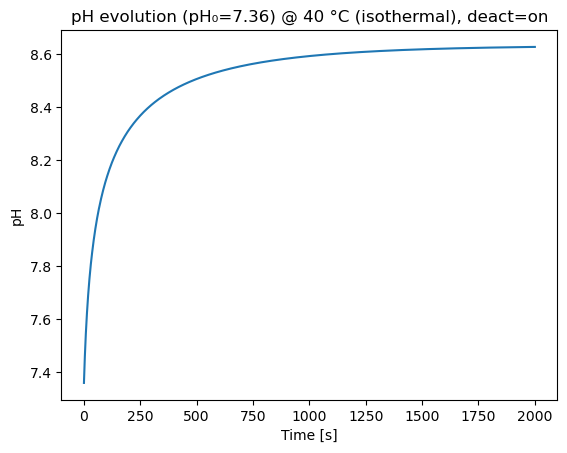

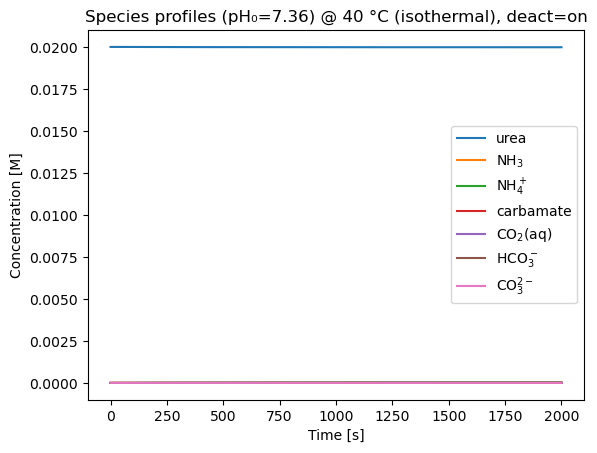

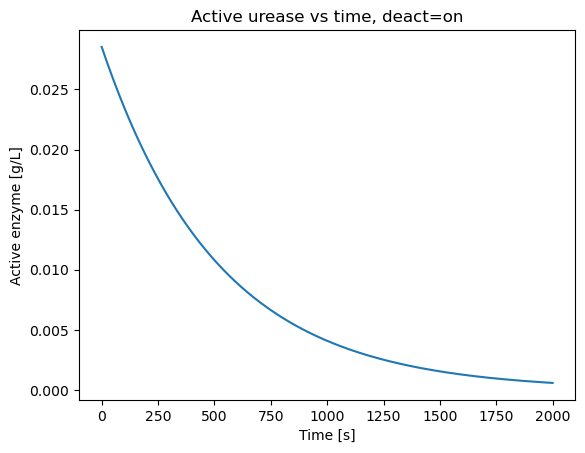

In [6]:
# Urease–urea batch reactor @ 40 °C (default isothermal), with optional
# unit-correct energy balance (adiabatic/jacketed), optional competitive
# phosphate inhibition, ASCII progress bar, temperature-dependent Kw,
# temperature-specific pH-activity, optional carbamate speciation,
# and a TOGGLEABLE first-order enzyme deactivation model.
#
# Stoich: urea -> 2 NH3 + CO2
#
# Notes to reproduce a fitted run:
# - Set activity_from_experiment = <activity_scale_from_fit>  (scales k0 only)
# - Set use_deactivation = True and k_deact_per_s = <value_from_fit>
# - Match initial_pH and temperature to your experiment
# - Keep NH3 stripping off unless you fitted it (not included here)

import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

# ╔══════════════════════════════════════════════════════════════╗
# ║                       USER SETTINGS                          ║
# ╚══════════════════════════════════════════════════════════════╝

# Volume & enzyme loading (mass-based)
volume_L               = 0.2           # reactor liquid volume [L]
grams_urease_powder    = 0.1           # mass of (effective) urease powder [g]
powder_activity_frac   = 1.0           # 0–1 scale for purity/activity
E_loading_g_per_L      = grams_urease_powder * powder_activity_frac / volume_L  # g/L

# Activity scale from fit (scales k0). Use your fitted value here.
activity_from_experiment = 0.057076306834491615  # ← put your fitted activity_scale

# Deactivation toggle & rate (first-order, fixed). Use your fitted value here.
use_deactivation = True                # True → use exp(-k_deact * t); False → stable activity
k_deact_per_s    = 0.0019434748888117876  # s^-1 (from fit). Ignored if use_deactivation=False

# Initial pH control (set None to disable strong-ion initialization)
initial_pH             = 7.36          # e.g., 6.0, 7.2, 8.5, or None

# Temperature control
isothermal             = True          # True: fixed 40 °C; False: simulate T via energy balance
fixed_temperature_K    = 313.15        # 40 °C (also used as initial T if non-isothermal)

# If isothermal == False, choose adiabatic/jacketed energy balance
adia                   = True          # only used if isothermal=False
UA_W_per_K             = 100.0         # overall U*A [W/K], if jacketed
T_jacket_K             = 313.15        # jacket temperature [K]
rho_kg_per_L           = 1.0           # per-liter basis
Cp_J_per_kgK           = 4184.0        # water cp
deltaH_J_per_mol       = -70.5e3       # reaction enthalpy (exothermic, keep negative)

# Chemistry: initial totals (no CO₂ steering)
S0                     = 0.020         # urea [M] (20 mM)
N0                     = 0.0           # total ammonia nitrogen [M] (NHx produced by urease)
C0                     = 0.0           # total inorganic carbon [M]
Pt_total_M             = 0.0           # total phosphate [M]; 0.0 = no phosphate

# Optional carbamate equilibrium NH3 + CO2 ⇌ NH2COO- + H+
include_carbamate      = False         # set True if you have a good Kcarb
Kcarb_dimensionless    = 1.0e-3        # K = [Carb][H+]/([NH3][CO2]); tune to your data if enabling

# Time control
auto_finish            = False          # stop when urea ~depleted
urea_cut_frac          = 1e-6          # stop when S < urea_cut_frac * S0
t_final_s              = 2000        # used only if auto_finish=False
n_points               = 15000        # samples written to CSV/plots

# Progress bar
show_progress          = True          # tqdm-like ASCII bar in terminal
progress_chunks        = 60            # number of chunks printed in bar

# Output
make_plots             = True
csv_path               = "simulation_results.csv"

# ╔══════════════════════════════════════════════════════════════╗
# ║                  CONSTANTS & PARAMETERS                      ║
# ╚══════════════════════════════════════════════════════════════╝

R   = 8.314  # J/mol/K

# Kinetics from Qin & Cabral (1994), per gram of enzyme
# k0 is a frequency factor (pre-exponential), NOT a Vmax at Tref.
# We scale k0 by the fitted activity factor (do NOT also scale mass, to avoid double counting).
k0_mol_per_s_per_g = 0.267 * activity_from_experiment   # mol NH3/(s·g) (frequency factor)
Ea    = 29.1e3                # J/mol
KM, Ks = 2.56e-3, 6.18        # M (Ks is indeed large in the paper)

# pH-activity parameters depend on temperature.
# 25 °C (298.15 K): pKa_es1=9.07, pKa_es2=5.62, alpha=0.373, beta=0.564
# 40 °C (313.15 K): pKa_es1=9.58, pKa_es2=5.15, alpha=0.542, beta=0.769
_PH_ACT_TABLE = [
    (298.15, 9.07, 5.62, 0.373, 0.564),
    (313.15, 9.58, 5.15, 0.542, 0.769),
]

def _interp_linear(x, x0, x1, y0, y1):
    if x <= x0: return y0
    if x >= x1: return y1
    w = (x - x0) / (x1 - x0)
    return y0 + w * (y1 - y0)

def pH_activity_params(TK):
    # linear interpolation between 25 °C and 40 °C
    (T0, pKa1_0, pKa2_0, a0, b0), (T1, pKa1_1, pKa2_1, a1, b1) = _PH_ACT_TABLE
    pKa1 = _interp_linear(TK, T0, T1, pKa1_0, pKa1_1)
    pKa2 = _interp_linear(TK, T0, T1, pKa2_0, pKa2_1)
    alpha = _interp_linear(TK, T0, T1, a0, a1)
    beta  = _interp_linear(TK, T0, T1, b0, b1)
    return pKa1, pKa2, alpha, beta

# ── Product inhibition Kp(pH) from Qin & Cabral (1994), table-based, clamped
_KP_POINTS = [
    (6.25, 0.1785),
    (6.50, 0.1194),
    (7.00, 0.0693),
    (7.50, 0.0386),
    (8.00, 0.0311),
    (8.50, 0.0327),
    (8.75, 0.0298),
    (9.00, 0.0310),
]
def Kp_of_pH(pH):
    pts = _KP_POINTS
    if pH <= pts[0][0]:
        return pts[0][1]
    if pH >= pts[-1][0]:
        return pts[-1][1]
    for (pa, Ka), (pb, Kb) in zip(pts, pts[1:]):
        if pa <= pH <= pb:
            w = (pH - pa) / (pb - pa)
            return Ka + w * (Kb - Ka)
    return pts[-1][1]

# Optional competitive phosphate inhibition (H2PO4- + HPO4^2- as “active”)
Ki_phosphate = 0.010  # [M] — larger means negligible inhibition; set None to disable

# Temperature-dependent water autoprotolysis (pKw table; clamp & linear interp)
# Typical values (pure water): 25°C:14.00, 35°C:~13.73, 40°C:~13.54, 50°C:~13.26
_PKW_TABLE = [
    (298.15, 14.00),
    (308.15, 13.73),
    (313.15, 13.54),
    (323.15, 13.26),
]
def pKw_of_T(TK):
    # piecewise linear interpolation with clamping
    if TK <= _PKW_TABLE[0][0]:
        return _PKW_TABLE[0][1]
    if TK >= _PKW_TABLE[-1][0]:
        return _PKW_TABLE[-1][1]
    for (Ta, pKwa), (Tb, pKwb) in zip(_PKW_TABLE, _PKW_TABLE[1:]):
        if Ta <= TK <= Tb:
            return _interp_linear(TK, Ta, Tb, pKwa, pKwb)
    return _PKW_TABLE[-1][1]

def Kw_of_T(TK):
    return 10.0 ** (-pKw_of_T(TK))

# Acid–base constants (held fixed; acceptable near 40 °C if you don't vary T far)
Ka_NH4 = 5.62e-10         # NH4+ ⇌ NH3 + H+
Ka1    = 4.45e-7          # H2CO3 ⇌ HCO3– + H+
Ka2    = 4.69e-11         # HCO3– ⇌ CO3^2–
# Phosphate triprotic
Ka1p   = 7.11e-3          # H3PO4 ⇌ H2PO4– + H+
Ka2p   = 6.32e-8          # H2PO4– ⇌ HPO4^2– + H+
Ka3p   = 4.22e-13         # HPO4^2– ⇌ PO4^3–

# ╔══════════════════════════════════════════════════════════════╗
# ║       INITIAL pH: STRONG-ION BACKGROUND (Na+ - Cl-)          ║
# ╚══════════════════════════════════════════════════════════════╝

B_STRONG = 0.0  # net strong-ion background [M], conserved

def _B_for_target_pH(pH_target, Ntot, Ctot, Ptot, T):
    """Compute net strong-ion background (Na+ - Cl-) [M] that yields pH_target under electroneutrality."""
    H  = 10**(-pH_target)
    Kw = Kw_of_T(T)
    OH = Kw / H

    # (carbamate handled below via helper)
    spec = _species_given_pH(H, Ntot, Ctot, Ptot, T, include_carbamate, Kcarb_dimensionless)
    NH4, HCO3, CO3, H2PO4, HPO4, PO4, Carb = spec['NH4'], spec['HCO3'], spec['CO3'], spec['H2PO4'], spec['HPO4'], spec['PO4'], spec['Carb']

    # From electroneutrality: (H + NH4 + Na+) = (OH + HCO3 + 2CO3 + H2PO4 + 2HPO4 + 3PO4 + Carb + Cl-)
    # Let B = [Na+] - [Cl-]. Rearranged: B = RHS - LHS (without Na+/Cl-).
    B = (OH + HCO3 + 2*CO3 + H2PO4 + 2*HPO4 + 3*PO4 + Carb) - (H + NH4)
    return B

# ╔══════════════════════════════════════════════════════════════╗
# ║              SPECIATION & pH  (charge balance)               ║
# ╚══════════════════════════════════════════════════════════════╝

_SPEC_LAST_pH = {"val": 7.0}  # warm start for root bracketing

def _carbon_alpha(H):
    # fraction functions for carbonate system (sum to 1)
    denom = H*H + Ka1*H + Ka1*Ka2
    a0 = H*H / denom           # CO2(aq)
    a1 = Ka1 * H / denom       # HCO3-
    a2 = Ka1 * Ka2 / denom     # CO3(2-)
    return a0, a1, a2

def _species_given_pH(H, Ntot, Ctot, Ptot, T, use_carbamate, Kcarb):
    Kw = Kw_of_T(T)
    OH = Kw / H

    # phosphate distributions
    Dp   = H**3 + Ka1p*H**2 + Ka1p*Ka2p*H + Ka1p*Ka2p*Ka3p
    H2PO4 = Ptot * (Ka1p * H**2 / Dp)
    HPO4  = Ptot * (Ka1p * Ka2p * H / Dp)
    PO4   = Ptot * (Ka1p * Ka2p * Ka3p / Dp)

    # If no carbamate: classic NH3/NH4 and carbonate split
    if not use_carbamate or Kcarb <= 0.0 or Ctot <= 0.0 or Ntot <= 0.0:
        NH4 = Ntot * (H / (H + Ka_NH4))
        NH3 = Ntot - NH4
        a0, a1, a2 = _carbon_alpha(H)
        CO2  = Ctot * a0
        HCO3 = Ctot * a1
        CO3  = Ctot * a2
        Carb = 0.0
        return {
            'H': H, 'OH': OH, 'NH3': NH3, 'NH4': NH4,
            'CO2': CO2, 'HCO3': HCO3, 'CO3': CO3,
            'H2PO4': H2PO4, 'HPO4': HPO4, 'PO4': PO4,
            'Carb': Carb
        }

    # With carbamate: solve analytically for N_free (NH3+NH4) and Carb
    a0, a1, a2 = _carbon_alpha(H)  # CO2, HCO3, CO3 fractions for the "free" carbon pool
    Ka = Ka_NH4
    beta = Kcarb * a0 / H                  # beta(H)
    gamma = beta * Ka / (H + Ka)          # gamma(H)

    # Quadratic for N_free: a*x^2 + b*x + c = 0, where x = N_free
    a = gamma
    b = 1.0 - gamma * (Ntot - Ctot)
    c = -Ntot

    if a <= 1e-20:
        N_free = max(Ntot, 0.0)
    else:
        disc = b*b - 4*a*c
        disc = max(disc, 0.0)
        N_free = ( -b + math.sqrt(disc) ) / (2*a)
        # Clamp physically
        N_free = max(min(N_free, max(Ntot, 0.0)), 0.0)

    # Now get Carb, then NH3/NH4 and the carbon species
    # Carb = (gamma*N_free)/(1 + gamma*N_free) * Ctot
    if gamma * N_free > 1e-20:
        Carb = (gamma * N_free / (1.0 + gamma * N_free)) * Ctot
    else:
        Carb = 0.0

    C_free = max(Ctot - Carb, 0.0)
    CO2  = a0 * C_free
    HCO3 = a1 * C_free
    CO3  = a2 * C_free

    # Ammonia speciation out of N_free
    NH4 = N_free * (H / (H + Ka))
    NH3 = N_free - NH4

    return {
        'H': H, 'OH': OH, 'NH3': max(NH3,0.0), 'NH4': max(NH4,0.0),
        'CO2': max(CO2,0.0), 'HCO3': max(HCO3,0.0), 'CO3': max(CO3,0.0),
        'H2PO4': H2PO4, 'HPO4': HPO4, 'PO4': PO4,
        'Carb': max(Carb,0.0)
    }

def _charge_balance_residual(pH, Ntot, Ctot, Ptot, T):
    H  = 10**(-pH)
    spec = _species_given_pH(H, Ntot, Ctot, Ptot, T, include_carbamate, Kcarb_dimensionless)
    OH = spec['OH']
    NH4 = spec['NH4']
    HCO3, CO3 = spec['HCO3'], spec['CO3']
    H2PO4, HPO4, PO4 = spec['H2PO4'], spec['HPO4'], spec['PO4']
    Carb = spec['Carb']

    # electroneutrality INCLUDING strong-ion background B_STRONG
    # (H + NH4 + Na+) - (OH + HCO3 + 2CO3 + H2PO4 + 2HPO4 + 3PO4 + Carb + Cl-) = 0
    # residual = LHS - RHS + B_STRONG
    return (H + NH4) - (OH + HCO3 + 2*CO3 + H2PO4 + 2*HPO4 + 3*PO4 + Carb) + B_STRONG

def compute_speciation(Ntot, Ctot, Ptot, T):
    """Return dict with pH and species for given totals at temperature T."""
    Ntot = max(Ntot, 0.0); Ctot = max(Ctot, 0.0); Ptot = max(Ptot, 0.0)

    # bracket around last pH guess
    pH0 = _SPEC_LAST_pH["val"]
    lo = max(1.0, pH0 - 3.0)
    hi = min(13.0, pH0 + 3.0)

    f_lo = _charge_balance_residual(lo, Ntot, Ctot, Ptot, T)
    f_hi = _charge_balance_residual(hi, Ntot, Ctot, Ptot, T)
    if f_lo * f_hi > 0:
        lo, hi = 1.0, 13.0

    sol = root_scalar(_charge_balance_residual, bracket=[lo, hi], method='brentq',
                      args=(Ntot, Ctot, Ptot, T))
    pH = float(sol.root)
    _SPEC_LAST_pH["val"] = pH

    H  = 10**(-pH)
    spec = _species_given_pH(H, Ntot, Ctot, Ptot, T, include_carbamate, Kcarb_dimensionless)
    spec.update({'pH': pH})
    return spec

# ╔══════════════════════════════════════════════════════════════╗
# ║                        RATE LAW                              ║
# ╚══════════════════════════════════════════════════════════════╝

def rate_per_g(S, Ntot, pH, T, P_inhib):
    """
    NH3 formation rate per gram of urease [mol/(g·s)].
    Arrhenius + temperature-specific pH activity + substrate inhibition
    + noncomp product inhibition (Kp(pH)) + optional competitive phosphate.
    """
    S = max(S, 0.0)

    # Arrhenius with k0 as frequency factor (scaled by activity_from_experiment)
    kT = k0_mol_per_s_per_g * math.exp(-Ea / (R * T))

    # pH activity (two-site), params interpolated by T
    pKa_es1, pKa_es2, alpha_e, beta_e = pH_activity_params(T)
    Kes1, Kes2 = 10**(-pKa_es1), 10**(-pKa_es2)
    H = 10**(-pH)
    pH_factor = 1.0 / (1.0 + (Kes1/H)**alpha_e + (H/Kes2)**beta_e)

    # competitive phosphate
    if Ki_phosphate is None or Ki_phosphate <= 0.0:
        alpha_comp = 1.0
    else:
        alpha_comp = 1.0 + P_inhib / Ki_phosphate

    denom = max(KM * alpha_comp + S + (S*S)/Ks, 1e-12)
    v_sub = kT * pH_factor * (S / denom)

    # noncompetitive product inhibition (uses total ammonia Ntot with pH-dependent Kp)
    v = v_sub / (1.0 + max(Ntot, 0.0) / max(Kp_of_pH(pH), 1e-12))
    return v

# ╔══════════════════════════════════════════════════════════════╗
# ║                        ODE SYSTEM                            ║
# ╚══════════════════════════════════════════════════════════════╝

def _E_active_at(t):
    """Active enzyme loading (g/L) with optional first-order deactivation."""
    if use_deactivation:
        return E_loading_g_per_L * math.exp(-max(k_deact_per_s, 0.0) * max(t, 0.0))
    else:
        return E_loading_g_per_L

def rhs_isothermal(t, y):
    """y = [S, Ntot, Ctot]; T is fixed."""
    S, Ntot, Ctot = y
    sp  = compute_speciation(Ntot, Ctot, Pt_total_M, fixed_temperature_K)
    pH  = sp['pH']
    Pin = sp['H2PO4'] + sp['HPO4']
    per_g = rate_per_g(S, Ntot, pH, fixed_temperature_K, Pin)
    r_NH3 = per_g * _E_active_at(t)               # mol/L/s
    dS_dt = -0.5 * r_NH3                          # urea → 2 NH3 + CO2
    dN_dt =        r_NH3
    dC_dt =  0.5 * r_NH3
    return [dS_dt, dN_dt, dC_dt]

def rhs_energy(t, y):
    """y = [S, Ntot, Ctot, T]; per-liter energy balance."""
    S, Ntot, Ctot, T = y
    sp  = compute_speciation(Ntot, Ctot, Pt_total_M, T)
    pH  = sp['pH']
    Pin = sp['H2PO4'] + sp['HPO4']
    per_g = rate_per_g(S, Ntot, pH, T, Pin)
    r_NH3 = per_g * _E_active_at(t)               # mol/L/s
    dS_dt = -0.5 * r_NH3
    dN_dt =        r_NH3
    dC_dt =  0.5 * r_NH3

    # heat release per liter
    r_urea = -dS_dt                                  # mol urea / (L·s)
    q_rxn_per_L = (-deltaH_J_per_mol) * r_urea       # J / (L·s)

    if adia:
        dT_dt = q_rxn_per_L / (rho_kg_per_L * Cp_J_per_kgK)
    else:
        UA_per_L = UA_W_per_K / volume_L             # W/K/L = J/(s·K·L)
        dT_dt = (q_rxn_per_L - UA_per_L * (T - T_jacket_K)) / (rho_kg_per_L * Cp_J_per_kgK)

    return [dS_dt, dN_dt, dC_dt, dT_dt]

def event_urea_depleted(t, y):
    S = y[0]
    return S - urea_cut_frac * S0
event_urea_depleted.terminal  = True
event_urea_depleted.direction = -1

# ╔══════════════════════════════════════════════════════════════╗
# ║               PROGRESS BAR & CHUNKED INTEGRATION             ║
# ╚══════════════════════════════════════════════════════════════╝

def _print_bar(frac_time, frac_conv, width=40):
    """ASCII progress bar: shows time progress and conversion estimate."""
    frac_time = max(0.0, min(1.0, frac_time))
    frac_conv = max(0.0, min(1.0, frac_conv))
    done = int(width * frac_time)
    bar  = '█' * done + '░' * (width - done)
    msg  = f"\r[{bar}] time {100*frac_time:5.3f}% | conv~{100*frac_conv:5.3f}%"
    sys.stdout.write(msg); sys.stdout.flush()

def integrate_with_progress(rhs, y0, times, chunks=50):
    """Integrate in 'chunks' and print a progress bar."""
    T_out = []
    Y_out = []
    edges = np.linspace(times[0], times[-1], chunks + 1)
    y_curr = np.array(y0, dtype=float)

    for k in range(chunks):
        t_a, t_b = edges[k], edges[k+1]
        mask = (times >= t_a) & (times <= t_b)
        t_eval_chunk = times[mask]
        if t_eval_chunk.size == 0:
            continue

        sol = solve_ivp(rhs, [t_a, t_b], y_curr, method='BDF',
                        t_eval=t_eval_chunk, max_step=60.0,
                        rtol=1e-6, atol=1e-12)
        if not sol.success:
            raise RuntimeError(f"Solve failed in chunk {k}: {sol.message}")

        if len(T_out) == 0:
            T_out = list(sol.t)
            Y_out = [arr.copy() for arr in sol.y]
        else:
            T_out.extend(list(sol.t[1:]))
            for i in range(len(sol.y)):
                Y_out[i] = np.concatenate((Y_out[i], sol.y[i][1:]))

        y_curr = sol.y[:, -1]

        # progress
        S_last = y_curr[0]
        frac_time = (t_b - times[0]) / (times[-1] - times[0] + 1e-12)
        denom = S0 * (1.0 - urea_cut_frac)
        frac_conv = min(1.0, max(0.0, (S0 - max(S_last, 0.0)) / (denom + 1e-30)))
        if show_progress:
            _print_bar(frac_time, frac_conv)

    if show_progress:
        sys.stdout.write("\n")
    return np.array(T_out), np.vstack(Y_out)

# ╔══════════════════════════════════════════════════════════════╗
# ║                INITIALIZE B_STRONG (from initial_pH)         ║
# ╚══════════════════════════════════════════════════════════════╝

if initial_pH is not None:
    T_for_init = fixed_temperature_K  # initial temperature context
    B_STRONG = _B_for_target_pH(initial_pH, N0, C0, Pt_total_M, T_for_init)
    _SPEC_LAST_pH["val"] = initial_pH  # warm start near requested pH
    print(f"[init] For pH0 = {initial_pH:.2f}, strong-ion net (Na+ - Cl-) = {B_STRONG:.4f} M")
else:
    B_STRONG = 0.0

# ╔══════════════════════════════════════════════════════════════╗
# ║                  SOLVE & BUILD DATAFRAME                     ║
# ╚══════════════════════════════════════════════════════════════╝

if isothermal:
    rhs = rhs_isothermal
    y0  = [S0, N0, C0]
else:
    rhs = rhs_energy
    y0  = [S0, N0, C0, fixed_temperature_K]

if auto_finish:
    sol_probe = solve_ivp(rhs, [0, 1e7], y0, method='BDF',
                          events=event_urea_depleted, max_step=60.0,
                          rtol=1e-6, atol=1e-12)
    if len(sol_probe.t_events) > 0 and len(sol_probe.t_events[0]) > 0:
        t_target = float(sol_probe.t_events[0][0])
    else:
        t_target = float(sol_probe.t[-1])
else:
    t_target = float(t_final_s)

times = np.linspace(0.0, t_target, n_points)
T_out, Y_out = integrate_with_progress(rhs, y0, times, chunks=progress_chunks)

records = []
if isothermal:
    for t, S, Ntot, Ctot in zip(T_out, *Y_out):
        sp = compute_speciation(Ntot, Ctot, Pt_total_M, fixed_temperature_K)
        records.append({
            'time [s]': t,
            'urea [M]': max(S, 0.0),
            'total ammonia [M]': max(Ntot, 0.0),
            'total inorganic carbon [M]': max(Ctot, 0.0),
            'pH': sp['pH'],
            'NH3 [M]': sp['NH3'],
            'NH4+ [M]': sp['NH4'],
            'Carbamate [M]': sp['Carb'],
            'CO2(aq) [M]': sp['CO2'],
            'HCO3- [M]': sp['HCO3'],
            'CO3(2-) [M]': sp['CO3'],
            'H2PO4- [M]': sp['H2PO4'],
            'HPO4(2-) [M]': sp['HPO4'],
            'PO4(3-) [M]': sp['PO4'],
            'T [K]': fixed_temperature_K,
            'T [°C]': fixed_temperature_K - 273.15,
            'E_active [g/L]': _E_active_at(t) * activity_from_experiment
        })
else:
    for t, S, Ntot, Ctot, T in zip(T_out, *Y_out):
        sp = compute_speciation(Ntot, Ctot, Pt_total_M, T)
        records.append({
            'time [s]': t,
            'urea [M]': max(S, 0.0),
            'total ammonia [M]': max(Ntot, 0.0),
            'total inorganic carbon [M]': max(Ctot, 0.0),
            'pH': sp['pH'],
            'NH3 [M]': sp['NH3'],
            'NH4+ [M]': sp['NH4'],
            'Carbamate [M]': sp['Carb'],
            'CO2(aq) [M]': sp['CO2'],
            'HCO3- [M]': sp['HCO3'],
            'CO3(2-) [M]': sp['CO3'],
            'H2PO4- [M]': sp['H2PO4'],
            'HPO4(2-) [M]': sp['HPO4'],
            'PO4(3-) [M]': sp['PO4'],
            'T [K]': T,
            'T [°C]': T - 273.15,
            'E_active [g/L]': _E_active_at(t) * activity_from_experiment
        })

df = pd.DataFrame(records)
df.to_csv(csv_path, index=False)

# ╔══════════════════════════════════════════════════════════════╗
# ║                          PLOTS                               ║
# ╚══════════════════════════════════════════════════════════════╝

if make_plots:
    def plain_axis(ax): ax.ticklabel_format(useOffset=False, style='plain', axis='y')
    title_pH = f" (pH₀={initial_pH:.2f})" if initial_pH is not None else ""
    title_T = (' @ 40 °C (isothermal)' if isothermal else '')
    title_deact = f", deact={'on' if use_deactivation else 'off'}"

    # pH vs time
    plt.figure()
    ax = plt.gca()
    plt.plot(df['time [s]'], df['pH'])
    plain_axis(ax)
    plt.xlabel('Time [s]'); plt.ylabel('pH')
    plt.title('pH evolution' + title_pH + title_T + title_deact)
    plt.savefig('pH_vs_time.png', bbox_inches='tight', dpi=150)

    # species vs time
    plt.figure()
    ax = plt.gca()
    for col, lbl in [
        ('urea [M]', 'urea'),
        ('NH3 [M]',  'NH$_3$'),
        ('NH4+ [M]', 'NH$_4^+$'),
        ('Carbamate [M]', 'carbamate'),
        ('CO2(aq) [M]', 'CO$_2$(aq)'),
        ('HCO3- [M]',   'HCO$_3^-$'),
        ('CO3(2-) [M]', 'CO$_3^{2-}$'),
    ]:
        plt.plot(df['time [s]'], df[col], label=lbl)
    plain_axis(ax)
    plt.xlabel('Time [s]'); plt.ylabel('Concentration [M]')
    plt.legend(); plt.title('Species profiles' + title_pH + title_T + title_deact)
    plt.savefig('species_vs_time.png', bbox_inches='tight', dpi=150)

    # active enzyme vs time (helps visualize deactivation)
    plt.figure()
    ax = plt.gca()
    plt.plot(df['time [s]'], df['E_active [g/L]'])
    plain_axis(ax)
    plt.xlabel('Time [s]'); plt.ylabel('Active enzyme [g/L]')
    plt.title('Active urease vs time' + title_deact)
    plt.savefig('E_active_vs_time.png', bbox_inches='tight', dpi=150)

# Final printout
if auto_finish:
    print(f"Finished at t = {times[-1]:.1f} s when S < {urea_cut_frac*100:.4g}% of S0.")
else:
    print("Finished fixed-time run.")
if use_deactivation and k_deact_per_s > 0:
    t_half = math.log(2.0)/k_deact_per_s
    print(f"Deactivation ON: k_deact = {k_deact_per_s:.4g} s^-1 (half-life ~ {t_half/3600:.2f} h)")
else:
    print("Deactivation OFF: enzyme activity held constant.")
print(f"Data → {csv_path}; figures saved as PNGs.")
